In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import glob

In [ ]:
img_paths = glob.glob('./bmw/*')

# 

In [ ]:
img_paths

['./bmw/149470462.jpg',
 './bmw/150105059.jpg',
 './bmw/150126693.jpg',
 './bmw/149144058.jpg',
 './bmw/150302723.jpg',
 './bmw/150151221.jpg',
 './bmw/150201333.jpg',
 './bmw/149381095.thumb.jpg',
 './bmw/150153540.thumb.jpg',
 './bmw/149153507.thumb.jpg',
 './bmw/149382552.jpg',
 './bmw/150176130.jpg',
 './bmw/6338367412_abfbb2421a_z.jpeg',
 './bmw/149385066.jpg',
 './bmw/150124091.thumb.jpg',
 './bmw/150123831.thumb.jpg',
 './bmw/149117459.jpg',
 './bmw/149118878.jpg',
 './bmw/150199659.jpg',
 './bmw/149470876.jpg',
 './bmw/7894238946_20405da846_o.jpg',
 './bmw/149150962.jpg',
 './bmw/150304381.jpg',
 './bmw/150080973.thumb.jpg',
 './bmw/150200633.jpg',
 './bmw/149382098.jpg',
 './bmw/149127425.jpg',
 './bmw/149109724.jpg',
 './bmw/149383718.jpg',
 './bmw/150084715.thumb.jpg',
 './bmw/149124216.jpg',
 './bmw/150124042.jpg',
 './bmw/149108439.jpg',
 './bmw/149479931.jpg',
 './bmw/150236516.jpg',
 './bmw/149107567.thumb.jpg',
 './bmw/150085649.thumb.jpg',
 './bmw/150303689.jpg',
 './b

In [ ]:
len(img_paths)

512

In [ ]:
%%time
cars = np.zeros(shape =(len(img_paths), 100, 100, 3))
for i in range(len(img_paths)):
    test_image = image.load_img(img_paths[i], target_size=(100, 100)) #, color_mode='grayscale')
    test_image= image.img_to_array(test_image)
    test_image = test_image/255
    cars[i,:,:,:] = test_image

CPU times: user 3.89 s, sys: 93.2 ms, total: 3.99 s
Wall time: 4 s


In [ ]:
cars.shape

(512, 100, 100, 3)

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow as tf
from IPython import display

In [ ]:
labels = np.ones((512,))
labels[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
labels.shape

(512,)

In [ ]:
train_images = cars.astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [ ]:
BUFFER_SIZE = 600
BATCH_SIZE = 100

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
train_dataset

<BatchDataset shapes: (None, 100, 100, 3), types: tf.float32>

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Activation,BatchNormalization,LeakyReLU,Conv2DTranspose,Reshape
def generator_model():
    model = Sequential()
    model.add(Dense(25*25*256, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((25, 25, 256)))
    assert model.output_shape == (None, 25, 25, 256) # Note: None is the batch size

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 25, 25, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 50, 50, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 100, 100, 3)

    return model

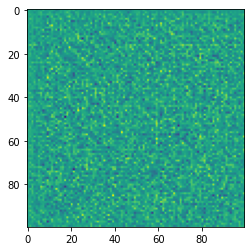

In [ ]:
generator = generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0]) #, cmap='gray')

In [ ]:
def discriminator_model():
    model = Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[100, 100, 3]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))

    return model

In [ ]:
discriminator = discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00010966]], shape=(1, 1), dtype=float32)


In [ ]:
from tensorflow.keras.losses import BinaryCrossentropy
# This method returns a helper function to compute cross entropy loss
cross_entropy = BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
from tensorflow.keras.optimizers import Adam
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

In [ ]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    #if (epoch + 1) % 15 == 0:
      #checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5) #, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

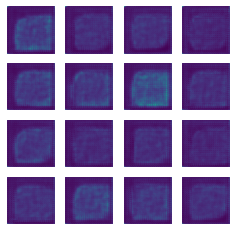

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('./image_at_epoch_0050.png')


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['display', 'seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


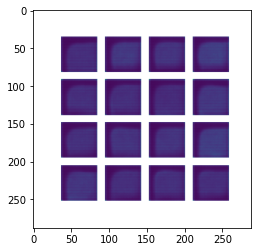

In [ ]:

imgplot = plt.imshow(img)
plt.show()
